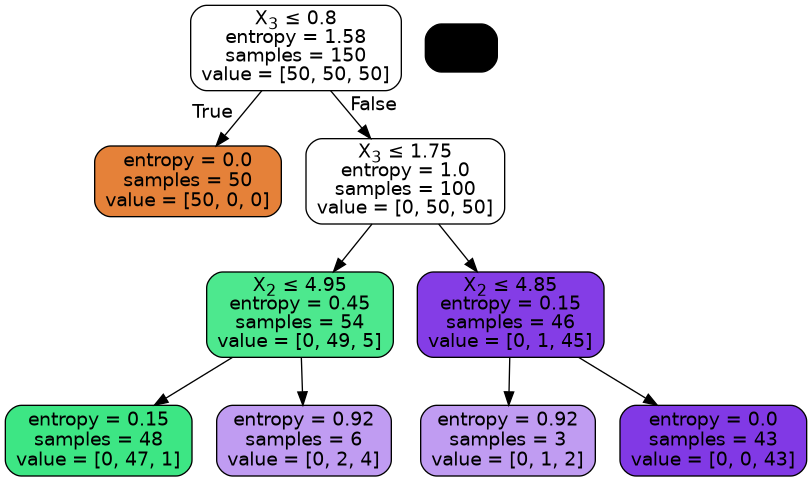

In [3]:
import pandas as pd
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
 
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
y = iris.target


# ID3分类树，信息增益特征选择
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(df, y)

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file = dot_data, filled = True, rounded = True, 
                special_characters = True, precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [7]:
iris.data.shape

(150, 4)

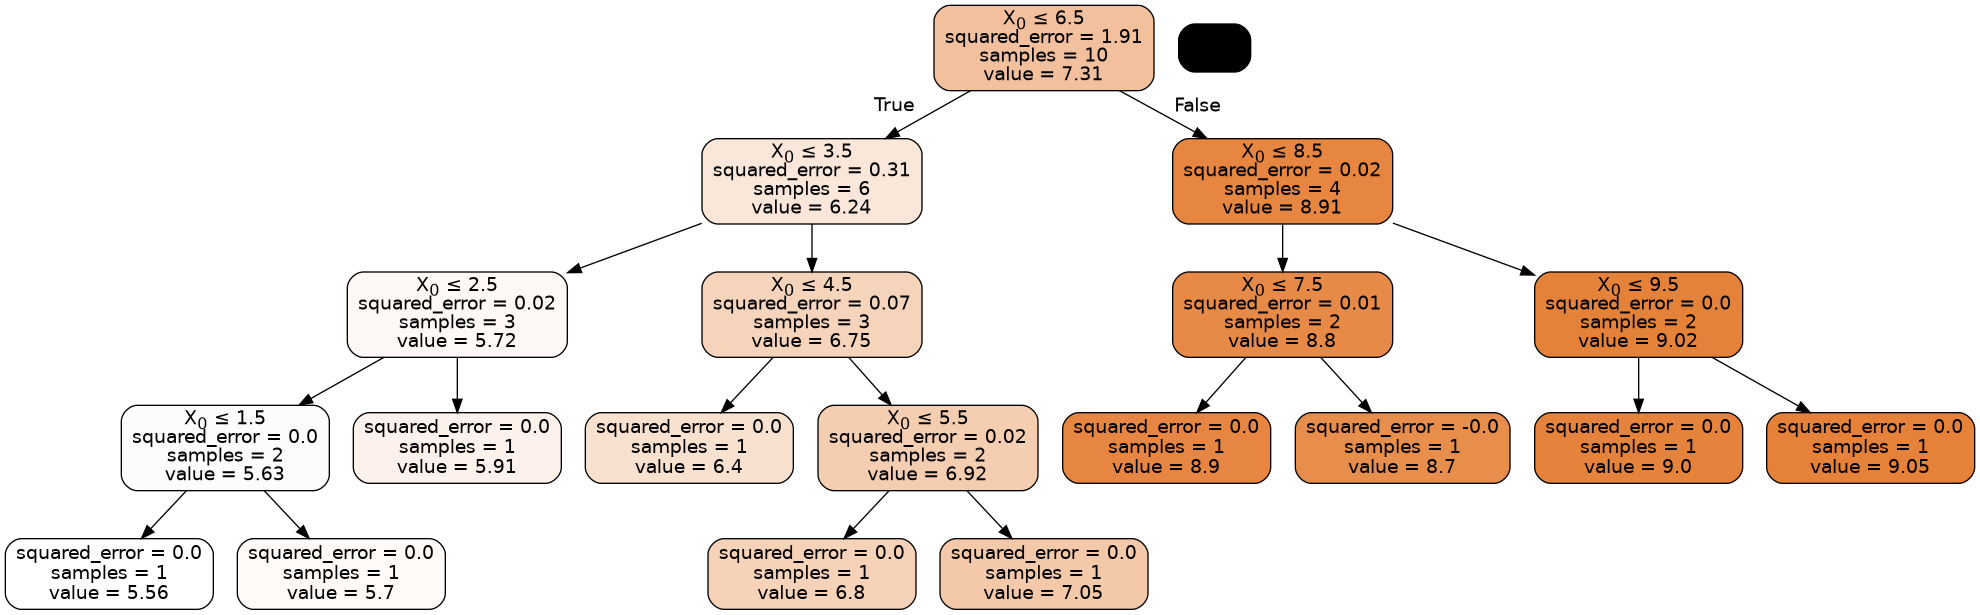

In [9]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

X = np.arange(1, 11).reshape(-1, 1)
y = np.array([5.56, 5.70, 5.91, 6.40, 6.80, 7.05, 8.90, 8.70, 9.00, 9.05])

tree = DecisionTreeRegressor(max_depth=4).fit(X, y)

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(tree, out_file=None,  
                filled=True, rounded=True,
                special_characters=True,
                precision=2)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [10]:
# Python 实现 Boosting Tree

from collections import defaultdict
import numpy as np


class BoostingTree:
    def __init__(self, error=1e-2):
        self.error = error  # 误差值
        self.candidate_splits = []  # 候选切分点
        self.split_index = defaultdict(tuple)  # 由于要多次切分数据集，故预先存储，切分后数据点的索引
        self.split_list = []  # 最终各个基本回归树的切分点
        self.c1_list = []  # 切分点左区域取值（均值）
        self.c2_list = []  # 切分点右区域取值（均值）
        self.N = None      # 数组元素个数
        self.n_split = None  # 切分点个数

    # 切分数组函数
    def split_arr(self, X_data):
        self.N = X_data.shape[0]
        # 候选切分点——前后两个数的中间值
        for i in range(1, self.N):
            self.candidate_splits.append((X_data[i][0] + X_data[i - 1][0]) / 2)
        self.n_split = len(self.candidate_splits)
        # 切成两部分
        for split in self.candidate_splits:
            left_index = np.where(X_data[:, 0] <= split)[0]
            right_index = np.where(X_data[:, 0] > split)[0]
            self.split_index[split] = (left_index, right_index)
        return

    # 计算每个切分点的误差
    def calculate_error(self, split, y_result):
        indexs = self.split_index[split]
        left = y_result[indexs[0]]
        right = y_result[indexs[1]]

        c1 = np.sum(left) / len(left)  # 左均值
        c2 = np.sum(right) / len(right)
        y_result_left = left - c1
        y_result_right = right - c2
        result = np.hstack([y_result_left, y_result_right])   # 数据拼接
        result_square = np.apply_along_axis(lambda x: x ** 2, 0, result).sum()
        return result_square, c1, c2

    # 获取最佳切分点，并返回对应的残差
    def best_split(self,y_result):
        # 默认第一个为最佳切分点
        best_split = self.candidate_splits[0]
        min_result_square, best_c1, best_c2 = self.calculate_error(best_split, y_result)

        for i in range(1, self.n_split):
            result_square, c1, c2 = self.calculate_error(self.candidate_splits[i], y_result)
            if result_square < min_result_square:
                best_split = self.candidate_splits[i]
                min_result_square = result_square
                best_c1 = c1
                best_c2 = c2

        self.split_list.append(best_split)
        self.c1_list.append(best_c1)
        self.c2_list.append(best_c2)
        return

    # 基于当前组合树，预测X的输出值
    def predict_x(self, X):
        s = 0
        for split, c1, c2 in zip(self.split_list, self.c1_list, self.c2_list):
            if X < split:
                s += c1
            else:
                s += c2
        return s

    # 每添加一颗回归树，就要更新y,即基于当前组合回归树的预测残差
    def update_y(self, X_data, y_data):
        y_result = []
        for X, y in zip(X_data, y_data):
            y_result.append(y - self.predict_x(X[0]))  # 残差
        y_result = np.array(y_result)
        print(np.round(y_result,2))  # 输出每次拟合训练数据的残差
        res_square = np.apply_along_axis(lambda x: x ** 2, 0, y_result).sum()
        return y_result, res_square

    def fit(self, X_data, y_data):
        self.split_arr(X_data)
        y_result = y_data
        while True:
            self.best_split(y_result)
            y_result, result_square = self.update_y(X_data, y_data)
            if result_square < self.error:
                break
        return

    def predict(self, X):
        return self.predict_x(X)


if __name__ == '__main__':
    data = np.array([[1, 5.56], [2, 5.70], [3, 5.91], [4, 6.40], [5, 6.80],
                     [6, 7.05], [7, 8.90], [8, 8.70], [9, 9.00], [10, 9.05]])
    X_data = data[:, :-1]
    y_data = data[:, -1]
    bt = BoostingTree(error=0.18)
    bt.fit(X_data, y_data)
    print('切分点：', bt.split_list)
    print('切分点左区域取值:', np.round(bt.c1_list,2))
    print('切分点右区域取值:', np.round(bt.c2_list,2))

[-0.68 -0.54 -0.33  0.16  0.56  0.81 -0.01 -0.21  0.09  0.14]
[-0.16 -0.02  0.19 -0.06  0.34  0.59 -0.23 -0.43 -0.13 -0.08]
[-0.31 -0.17  0.04 -0.2   0.2   0.45 -0.01 -0.21  0.09  0.14]
[-0.15 -0.01  0.2  -0.04  0.09  0.34 -0.12 -0.32 -0.02  0.03]
[-0.22 -0.08  0.13 -0.11  0.02  0.27 -0.01 -0.21  0.09  0.14]
[-0.07  0.07  0.09 -0.15 -0.02  0.23 -0.05 -0.25  0.05  0.1 ]
切分点： [6.5, 3.5, 6.5, 4.5, 6.5, 2.5]
切分点左区域取值: [ 6.24 -0.51  0.15 -0.16  0.07 -0.15]
切分点右区域取值: [ 8.91  0.22 -0.22  0.11 -0.11  0.04]


In [12]:
import numpy as np

array = np.array([5.56, 5.70, 5.91, 6.40, 6.80, 7.05, 8.90, 8.70, 9.00, 9.05])
array - np.average(array)

array([-1.747, -1.607, -1.397, -0.907, -0.507, -0.257,  1.593,  1.393,
        1.693,  1.743])